# PCA Strategy: Flatteners and Steepeners

Given the PCA Var-Cov decomposition, we are going to conduct a strategy that is neutral to changes in the level of the curve (PC1 neutral), and delta neutral. 

Our PCA decomposition looks like the following:

$$  F_t = y_{t} E$$
$$y_{t} = F_t E^T$$ 

Where:

- $y_t$ is $(n, m)$ matrix with $n =$ number of periods (daily frequency) in-sample and $m$ forward swap tenors in our data set. *Note:* we are implementing the strategy using levels of rates rather than daily differences, as our strategy is not looking for intraday patterns.
- $F_t$ is the  $(n, f)$ matrix  of series of PCA scores, with $f$ number of factors to project (3 in our baseline case, ~97\% variance explained)
- $E$ $(f, m)$ matrix of eigenvectors of from the SVD decomposition of $\Sigma$, i.e. the loading of each PCA factor for each instrument. 
    - $\Sigma$ is computed with a long-term correlation structure for a given sample size, and with tenor volatilities $\sigma_i$ with a shorter span period.

## Steepeners and Flatteners

The two strategies that we will pursue are Steepeners and Flatteners:

- Steepener:
    - Upward sloping curve: long front end /short long end 
- Flattener: 
    - Upward sloping curve: short front end /long long end

We choose a set of pairs of shorter/longer rates, such as 1y1yvs4y1y, 2y1yvs10y5y and so on. For any pair, we defined a portfolio with weights $w_1, w_2$ such that the $i$-th portfolio strategy $ i = 1,....,N$, $\Pi^i_t$, is neutral to $\text{PCA}_1$ factor: 

$$ \Pi^i_t =  w_1 \cdot y^s_t + w_2 \cdot y^l_t$$
$$ \partial_{\text{PCA}_1} \Pi^i_t = w_1 \partial_{\text{PCA}_1} y^s_t + w_2\partial_{\text{PCA}_1} y^l_t = 0 $$

We know that from the PCA decompositions $\partial_{\text{PCA}_1} y^s_t = E_{(1, y^j_t)}, j = s,l$, the respective loading from the eigenvectors.

$$ w_1 \partial_{\text{PCA}_1} y^s_t + w_2\partial_{\text{PCA}_1} y^l_t = 0$$
$$ w_1 E_{(1, y^s_t)} + w_2 E_{(1, y^l_t)} = 0$$

Using the short-rate weights as the normalization weight, we set $w_1 = 1$ and so: 

$$ w_2  = - \frac{E_{(2, y^s_t)}}{E_{(2, y^l_t)}}$$

## Entry signal

Our entry signal is dervied from the Z-score of the portfolio given, where the mean and standard deviation are derived from the correlation rolling window, as:

$$\text{Z-score}^i = \frac{\Pi^t - \bar{\Pi^i}}{\sigma_{\Pi^i}}$$


We would enter a trade for $\text{Z-score} \geq |2|$ two or more standar deviation events. 









# Implementation of strategy

## Example using 1y1y vs 10y5y$
To examplify our approach, we fix period to compute the PCA, solve for the desired portfolio weights, compute the z-score and the look for the trading signal.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import module_rollingPCA_EMA as mod

from sklearn.decomposition import PCA

In [2]:
fwd_swap_rates = pd.read_excel("data/USD_SOFR.xlsx",
                      parse_dates=["Trade Day"], header=0)
fwd_swap_rates = fwd_swap_rates.set_index("Trade Day")
fwd_swap_rates = fwd_swap_rates.apply(pd.to_numeric, errors="coerce").dropna()
print("Start date in sample = {t}".format(t = fwd_swap_rates.index[0].strftime("%A, %B %d, %Y")))
print("End date in sample = {t}".format(t = fwd_swap_rates.index[-1].strftime("%A, %B %d, %Y")))
print("Number of daily observations = {n}".format(n = fwd_swap_rates.shape[0]))
print("Number of instruments = {m}".format(m = fwd_swap_rates.shape[1]))
print("Fwd Swap instruments = {ml}".format(ml = list(fwd_swap_rates.columns)))

Start date in sample = Tuesday, September 27, 2011
End date in sample = Wednesday, December 03, 2025
Number of daily observations = 3702
Number of instruments = 10
Fwd Swap instruments = ['USD1y1y', 'USD2y1y', 'USD3y1y', 'USD4y1y', 'USD5y2y', 'USD7y3y', 'USD10y5y', 'USD15y5y', 'USD20y5y', 'USD25y5y']


<Axes: >

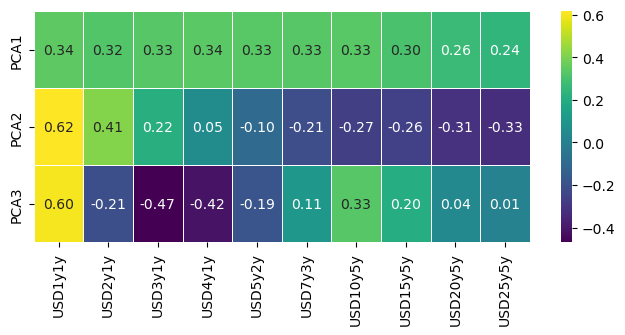

In [3]:
n_mats = len(fwd_swap_rates.columns)

train_start_date = "2011-10-01"
train_end_date = "2023-12-29"
test_start_date = "2024-01-01"
test_end_date = "2025-10-31"

training_sample = fwd_swap_rates.loc[train_start_date:train_end_date]
test_sample = fwd_swap_rates.loc[test_start_date:test_end_date]
pca = PCA(n_components=3).fit(training_sample)
E_matrix = pca.components_

selected_maturities = ['USD1y1y', 'USD2y1y', 'USD3y1y', 'USD4y1y', 'USD5y2y', 'USD7y3y', 'USD10y5y', 'USD15y5y', 'USD20y5y', 'USD25y5y']

E_display = pd.DataFrame(E_matrix, columns=fwd_swap_rates.columns, index=["PCA1", "PCA2", "PCA3"])[selected_maturities]
plt.figure(figsize=(8, 3))
sns.heatmap(E_display, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)


To compute the weights, we would need to solve for $w_2$ given $w_1 = 1$ from:

$$w_1*0.34 + w_2*0.33 = 0$$

In [4]:
E_pc1_1y1y = E_matrix[0, fwd_swap_rates.columns.get_loc("USD1y1y")]
E_pc1_10y5y = E_matrix[0, fwd_swap_rates.columns.get_loc("USD10y5y")]

w_1_normalized = 1
w_2_normalized = -E_pc1_1y1y/E_pc1_10y5y
print(f"Normalized Weight for 1y1y fwd swap: {w_1_normalized:.4f}")
print(f"Normalized Weight for 10y5y fwd swap: {w_2_normalized:.4f}")

Normalized Weight for 1y1y fwd swap: 1.0000
Normalized Weight for 10y5y fwd swap: -1.0294


Our spread with exposure to PCA 2 component is therefore:

$$\Pi^{\text{1y1yvs10y5y}}_t = 1 \cdot \text{1y1y}_t -  1.0294 \cdot \text{10y5y}_t$$

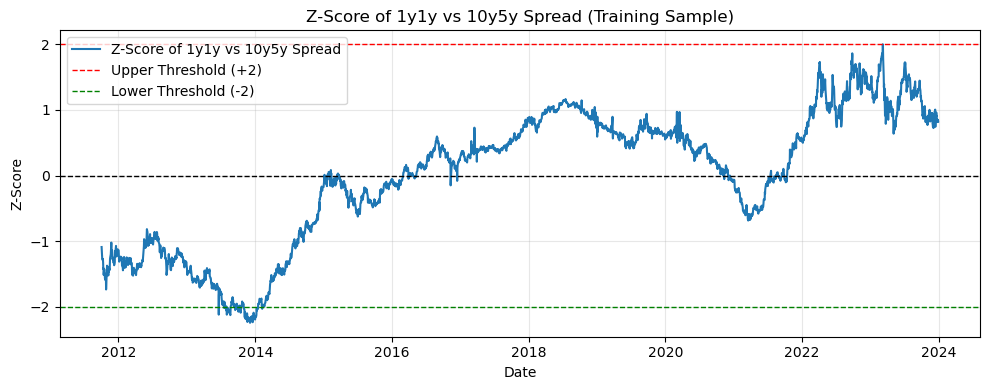

In [5]:
spread_1y1yvs10y5y = w_1_normalized * training_sample["USD1y1y"] + w_2_normalized * training_sample["USD10y5y"]
mean_spread = spread_1y1yvs10y5y.mean()
std_spread = spread_1y1yvs10y5y.std()
z_score_1y1yvs10y5y = (spread_1y1yvs10y5y - mean_spread) / std_spread

plt.figure(figsize=(10, 4))
plt.plot(z_score_1y1yvs10y5y.index, z_score_1y1yvs10y5y, label="Z-Score of 1y1y vs 10y5y Spread")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(2.0, color='red', linestyle='--', linewidth=1, label='Upper Threshold (+2)')
plt.axhline(-2.0, color='green', linestyle='--', linewidth=1, label='Lower Threshold (-2)')
plt.title("Z-Score of 1y1y vs 10y5y Spread (Training Sample)")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The out-of-sample signal for entering the trade on the spread, along with the spread in levels, would look like:

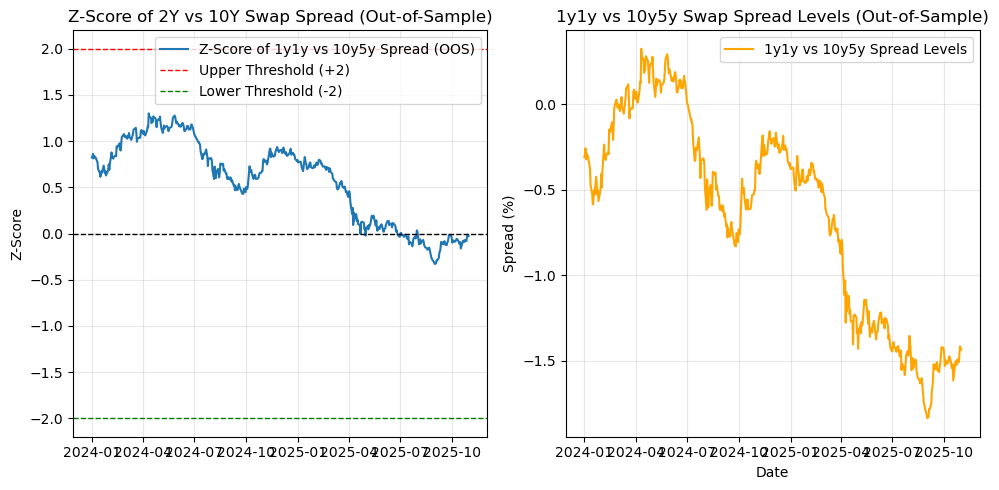

Z-score >0 signal []
Z-score <0 signal []


In [6]:
spread_1y1yvs10y5y_oos = w_1_normalized * test_sample["USD1y1y"] + w_2_normalized * test_sample["USD10y5y"]
z_score_1y1yvs10y5y_oos = (spread_1y1yvs10y5y_oos - mean_spread) / std_spread


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].plot(z_score_1y1yvs10y5y_oos.index, z_score_1y1yvs10y5y_oos, label="Z-Score of 1y1y vs 10y5y Spread (OOS)")
ax[0].axhline(0, color='black', linestyle='--', linewidth=1)
ax[0].axhline(2.0, color='red', linestyle='--', linewidth=1, label='Upper Threshold (+2)')
ax[0].axhline(-2.0, color='green', linestyle='--', linewidth=1, label='Lower Threshold (-2)')
ax[0].set_title("Z-Score of 2Y vs 10Y Swap Spread (Out-of-Sample)")
ax[0].set_ylabel("Z-Score")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(spread_1y1yvs10y5y_oos.index, spread_1y1yvs10y5y_oos, label="1y1y vs 10y5y Spread Levels", color='orange')
ax[1].set_title("1y1y vs 10y5y Swap Spread Levels (Out-of-Sample)")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Spread (%)")
ax[1].legend()
ax[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Z-score >0 signal" , z_score_1y1yvs10y5y_oos[z_score_1y1yvs10y5y_oos > 2.0].index.values)
print("Z-score <0 signal" , z_score_1y1yvs10y5y_oos[z_score_1y1yvs10y5y_oos < -2.0].index.values)

In the example above, we wouln't enter into a 1y1yvs10y5y trade.

## Creating the signal engine

In the following, we conduct the PCA analysis using the rolling window for the PCA loadings, and implement it systematically to every pair or spread of front end/ long end instruments.

For that, we split our available universe of instrumets and classify them as short-end or long-end, according to their sign with respect to the PCA2 from the above analysis. Short-end (long-end) instruments will be those with positive (negative) PC2 loadings. Once again, a trade will consist of a spread between short vs long end instrument.


- Front end: 'USD1y1y', 'USD2y1y', 'USD3y1y', 'USD4y1y'
- Long end: 'USD5y2y', 'USD7y3y', 'USD10y5y', 'USD15y5y', 'USD20y5y', 'USD25y5y'

------------------------------------------
--- Rolling Factor Weights Retrieved ---
--- Most recent calibration ---
                  w_1       w_2
Calibration_Date               
2023-10-24          1 -0.901857
2024-04-17          1 -0.914760
2024-10-10          1 -1.148461
2025-04-04          1 -0.968973
2025-09-29          1  0.894895
-----------------------------------
Signals, Positions and P&L done
-----------------------------------


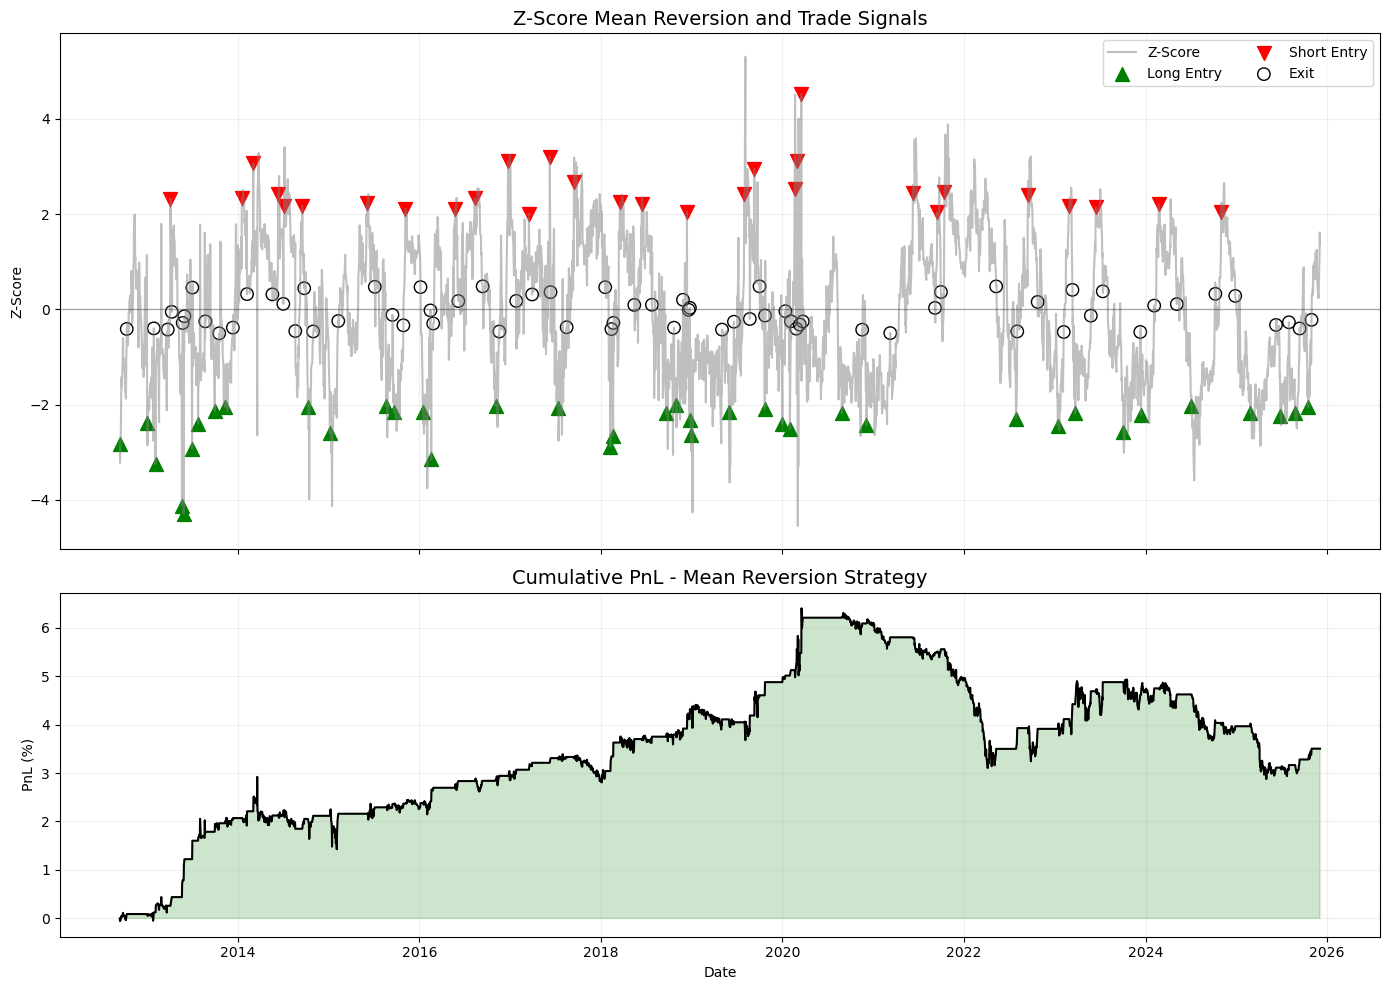

In [299]:
import module_rollingPCA_Spread as cm

#Global Parameters:
years_corr = 1
years_vol = 0.5
periods_corr = round(years_corr*252)
periods_vol = round(years_vol*252)
instruments = ["USD1y1y", "USD20y5y"]

rolling_spread = cm.SpreadTradesRollingPCA(fwd_swap_rates, periods_corr, periods_vol, instruments) #-> Instantiate object
_= rolling_spread.spread_weigths_rollPCA() # -> Set the weights 
mean_reversion_trading = rolling_spread.zscore_spread_trades(60, 2, 0.5) # -> Get z-score signals and position
results_dict = rolling_spread.summarize_trade_performance()
cm.plot_backtest_summary(mean_reversion_trading)


In [296]:
#risk_free_rate = fwd_swap_rates['USD1y1y'].mean()/100
risk_free_rate = 0.0
strategy_results = cm.strategy_metrics(mean_reversion_trading, risk_free_rate)
for k, v in strategy_results.items():
    print(f"{k}: {v:.2%}" if "Ratio" not in k else f"{k}: {v:.2f}")
print("Risk Free Rate: {r:.2%}".format(r = risk_free_rate))

Total Return: 16.38%
Annualized Return: 1.11%
Annualized Volatility: 0.88%
Sharpe Ratio: 1.25
Max Drawdown: -1.31%
Risk Free Rate: 0.00%


In [297]:
results_dict = rolling_spread.summarize_trade_performance()
results_dict['By_Year']

,Count,Wins,Losses,Avg_Holding_Period,Avg_Return_per_Trade,Max. Return,Min. Return,Avg_Vol_per_Trade,Avg_Sharpe_Ratio,Win_Rate
Year,,,,,,,,,,
2012,3.0,3.0,0.0,12.0,0.279895,0.463642,0.018232,0.135059,2.072387,1.000000
2013,7.0,1.0,6.0,14.0,-0.097233,0.055008,-0.493979,0.136213,-0.713831,0.142857
2014,11.0,7.0,4.0,5.0,0.086384,0.332030,0.000000,0.066422,1.300544,0.636364
2015,8.0,6.0,2.0,8.0,0.065093,0.247930,-0.071105,0.057409,1.133841,0.750000
2016,7.0,4.0,3.0,14.0,0.086814,0.529784,-0.245135,0.088155,0.984789,0.571429
2017,11.0,8.0,3.0,4.0,0.055573,0.164524,0.000000,0.065067,0.854085,0.727273
2018,12.0,5.0,7.0,6.0,-0.016187,0.093235,-0.262171,0.090192,-0.179469,0.416667
2019,18.0,8.0,10.0,2.0,0.112928,0.573975,0.000000,0.192568,0.586433,0.444444
2020,5.0,3.0,2.0,15.0,0.127404,0.335224,-0.043140,0.115683,1.101325,0.600000


In [276]:
#plt.plot(z_scores.index, z_scores['Z_Score'])
mean_reversion_trading.head(15)

,Z_Score,Position,Portfolio_val,Simple_spread,Daily_PnL,Mean,Sigma,w_S,w_L,Calibration_Date,Trade_date,Cumulative_PnL,Cumulative_Index,Trade_ID,prev_pos
Trade Day,,,,,,,,,,,,,,,
2012-03-21,0.441838,0.0,-0.376242,-0.422103,-0.000000,-0.417085,0.092439,1.0,-0.985932,2012-03-21,2012-03-21,-0.000000,100.000000,1,0.0
2012-03-22,0.893798,0.0,-0.319128,-0.364234,0.000000,-0.393756,0.083496,1.0,-0.985932,2012-03-21,2012-03-22,0.000000,100.000000,1,0.0
2012-03-23,-0.509058,0.0,-0.402243,-0.446390,-0.000000,-0.375809,0.051926,1.0,-0.985932,2012-03-21,2012-03-23,0.000000,100.000000,1,0.0
2012-03-26,-1.467373,0.0,-0.461617,-0.506859,-0.000000,-0.378945,0.056340,1.0,-0.985932,2012-03-21,2012-03-26,0.000000,100.000000,1,0.0
2012-03-27,-0.403750,0.0,-0.406377,-0.450990,0.000000,-0.383554,0.056529,1.0,-0.985932,2012-03-21,2012-03-27,0.000000,100.000000,1,0.0
2012-03-28,0.260588,0.0,-0.373227,-0.418274,0.000000,-0.387340,0.054161,1.0,-0.985932,2012-03-21,2012-03-28,0.000000,100.000000,1,0.0
2012-03-29,-1.068330,0.0,-0.446357,-0.491990,-0.000000,-0.387860,0.054756,1.0,-0.985932,2012-03-21,2012-03-29,0.000000,100.000000,1,0.0
2012-03-30,-0.955232,0.0,-0.437827,-0.483221,0.000000,-0.386747,0.053474,1.0,-0.985932,2012-03-21,2012-03-30,0.000000,100.000000,1,0.0
2012-04-02,-1.099213,0.0,-0.458817,-0.504421,-0.000000,-0.399539,0.053928,1.0,-0.985932,2012-03-21,2012-04-02,0.000000,100.000000,1,0.0


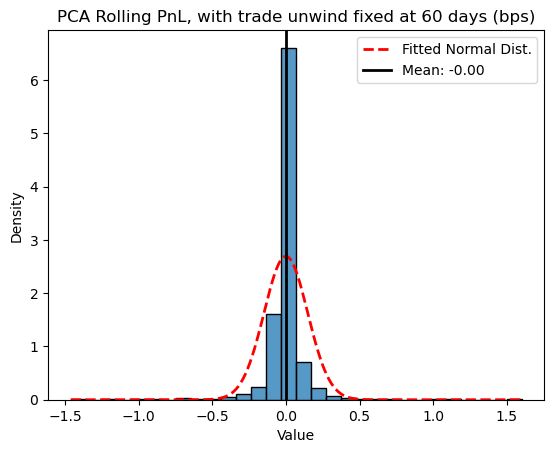

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# 1. Generate sample data (replace with your own data)
np.random.seed(0) # for reproducibility
data = mean_reversion_trading[mean_reversion_trading['Position'] != 0]['Daily_PnL']
data_mean = np.mean(data)
data_std = np.std(data)

# 2. Create the histogram and get the axes object
# Use stat='density' so the y-axis aligns with the PDF
ax = sns.histplot(data, bins=30, stat='density', kde=False)

# 3. Overlay the fitted normal distribution curve
# Get x values for the normal PDF
x_values = np.linspace(min(data), max(data), 200)
pdf = norm.pdf(x_values, data_mean, data_std)

# Plot the PDF using matplotlib's plot function
ax.plot(x_values, pdf, color='red', linestyle='--', linewidth=2, label='Fitted Normal Dist.')

# 4. Add a vertical line for the mean
ax.axvline(data_mean, color='black', linestyle='-', linewidth=2, label=f'Mean: {data_mean:.2f}')

# 5. Customize the plot
ax.set_title('PCA Rolling Daily PnL Distribution')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

# 6. Display the plot
plt.show()

In [ ]:
mean_reversion_trading.to_excel("Trades_DynamicWindow.xlsx")